## Compare Step-Index computations

### Imports

In [20]:
%load_ext autoreload
%autoreload 2

from IPython.display import clear_output
from scipy.io import savemat

import gc
import os
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np

from mmfsim.phase import LinearPhase
from mmfsim.grid import Grid
from mmfsim.fiber import StepIndexFiber
from mmfsim.beams import GaussianBeam
from mmfsim.speckle import DegenStepIndexSpeckle
from mmfsim.coupling import StepIndexFiberDegenCoupler
from mmfsim.transforms import fourier_transform
from mmfsim.devices import MockDeformableMirror

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Simulation variables

In [21]:
fiber_radius = 25e-6
fiber_length = 1e0
power_n = 7
power_n_fourier = 11
grid_length_fourier = 2 ** power_n_fourier
grid_length = 2 ** power_n
grid_size = 2 * fiber_radius
pixel_size = grid_size / grid_length

fiber_kwargs = dict(radius=fiber_radius, wavelength=1064e-9, n1=1.4665, n2=1.45)
grid_kwargs = dict(pixel_size=pixel_size, pixel_numbers=(grid_length, grid_length))

### Define the fiber

In [22]:
grid = Grid(**grid_kwargs)
fiber = StepIndexFiber(**fiber_kwargs)
print(fiber)

c:\users\saucourt\coding\mmf_lp_modes\mmfsim\fiber.py:247: RuntimeWarning: invalid value encountered in sqrt
  w = np.sqrt(v**2 - u**2)
c:\users\saucourt\coding\mmf_lp_modes\mmfsim\fiber.py:248: RuntimeWarning: invalid value encountered in divide
  return sp.jv(n, u) / (u * sp.jv(n - 1, u)) + sp.kn(n, w) / (w * sp.kn(n - 1, w))


StepIndexFiber instance with:
  - Radius: 25.0 um
  - Core index: 1.4665
  - Cladding index: 1.45
  - Wavelength: 1064.0 nm
  - Numerical aperture: 0.219
  - Number of guided LP modes: 140
  - Number of guided LP modes (counting degenerates): 269
  - First 10 LP_n,m modes characteristics:
  n_eff      h          n          m
[[ 1.46641487  0.          0.          1.        ]
 [ 1.46628389  2.          1.          1.        ]
 [ 1.46611179  4.          2.          1.        ]
 [ 1.46605151  1.          0.          2.        ]
 [ 1.46590084  6.          3.          1.        ]
 [ 1.46577563  3.          1.          2.        ]
 [ 1.46565244  8.          4.          1.        ]
 [ 1.46545734  5.          2.          2.        ]
 [ 1.46539799  2.          0.          3.        ]
 [ 1.46536754 10.          5.          1.        ]]


In [23]:
fiber.compute_modes_fields(grid)
clear_output(wait=False)

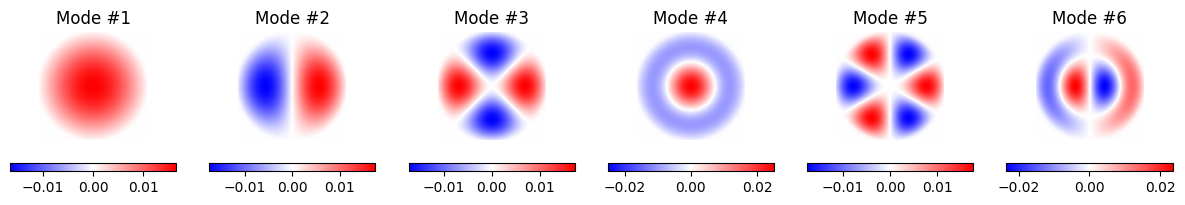

In [24]:
plt.figure(figsize=(15, 2))

max_modes = 6

for i in range(max_modes):
    plt.subplot(1, max_modes, i+1)
    mode = fiber._modes[:, :, 0, i]
    plt.imshow(mode, cmap='bwr', vmin=-np.max(np.abs(mode)), vmax=+np.max(np.abs(mode)))
    plt.axis('off')
    plt.title(f'Mode #{i+1}')
    plt.colorbar(orientation='horizontal')

### Define fitness and helpful functions

In [ ]:
from waveoptics.metrics.numpy import quality, pearson
import torch
from torch.nn import AdaptiveAvgPool2d, UpsamplingNearest2d

def convert_field_to_dm(field: np.array, n: int):
    with torch.no_grad():
        downsampler = AdaptiveAvgPool2d(output_size=(n, n))
        upsampler =  UpsamplingNearest2d(size=field.shape)

        downsampled = (
            downsampler(torch.from_numpy(np.real(field[np.newaxis, np.newaxis, ...])))
            + 1j * downsampler(torch.from_numpy(np.imag(field[np.newaxis, np.newaxis, ...])))
        )

        resampled = (
            upsampler(torch.real(downsampled))
            + 1j * upsampler(torch.imag(downsampled))
        )

    return resampled.squeeze().cpu().detach().numpy()




def make_diagonal_mode_coupling_matrix(fiber, fiber_length) -> np.ndarray:
    prop_constants = fiber._prop_constants.copy() # Columns with beta, n_eff, n, m, u, w
    print(prop_constants.shape)

    degen_betas = np.zeros(shape=(fiber._N_modes_degen))
    k = 0
    for i in range(fiber._N_modes):
        if prop_constants[i, 2] == 0: # Mode is centro-symmetric
            degen_betas[k] = prop_constants[i, 0]
            k += 1
        else: # Mode is not centro-symmetric
            degen_betas[k] = prop_constants[i, 0]
            degen_betas[k+1] = prop_constants[i, 0]
            k += 2

    propagation_matrix = np.diag(np.exp(-1j * degen_betas * fiber_length))
    return propagation_matrix


def generate_input_beam(x_reim) -> np.ndarray:
    # phase = LinearPhase(grid)
    # phase.compute(coeffs=[0.5e-4, 1])

    beam = GaussianBeam(grid)
    beam.compute(amplitude=1, width=fiber.radius/2, centers=[0, 0])
    beam.field = np.complex64(fiber._modes[:, :, 0, 0])
    # beam.add_phase(phase.phase)
    beam.normalize_by_energy()

    n2 = x_reim.size
    re_map = x_reim[:n2//2]
    im_map = x_reim[n2//2:]
    n = int(np.sqrt(x_reim.size // 2))

    cplx_map = re_map.reshape(n, n) + 1j * im_map.reshape(n, n)

    dm = MockDeformableMirror(pixel_size=grid.pixel_size, pixel_numbers=grid.pixel_numbers, diameter=2.4*fiber.radius, offsets=(0*fiber.radius, 0))
    dm.apply_phase_map(np.angle(cplx_map))
    dm.apply_amplitude_map(np.abs(cplx_map))


    beam.field *= dm._field_matrix
    return beam.field


def couple_input_beam(field):
    coupled_in = StepIndexFiberDegenCoupler(field, grid, fiber, N_modes=fiber._N_modes_degen)
    return coupled_in


def propagate(coupled_in, propagation_matrix) -> np.ndarray:
    new_coeffs = propagation_matrix @ coupled_in.modes_coeffs

    coupled_out = deepcopy(coupled_in)
    coupled_out.modes_coeffs = new_coeffs
    coupled_out.recompose()

    return coupled_out


def get_output_field_from_reim(reim, propagation_matrix):
    field = generate_input_beam(reim)
    coupled_in = couple_input_beam(field)
    coupled_out = propagate(coupled_in, propagation_matrix)
    return coupled_out


def fitness_function_from_reim(reim, target_field, propagation_matrix):
    coupled_out = get_output_field_from_reim(reim, propagation_matrix)
    # loss = -quality(coupled_out.field / np.max(np.abs(coupled_out.field)), target_field / np.max(np.abs(target_field)), squared=True)
    # loss = -pearson(np.square(np.abs(coupled_out.field)), np.square(np.abs(target_field)))
    loss = -np.square(np.abs(coupled_out.modes_coeffs[2]))
    return loss

### Optimize using CMA-ES from Nevergrad

(140, 6)


c:\users\saucourt\coding\mmf_lp_modes\mmfsim\speckle.py:383: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  # Pivot the table: n as index, m+orientation as columns


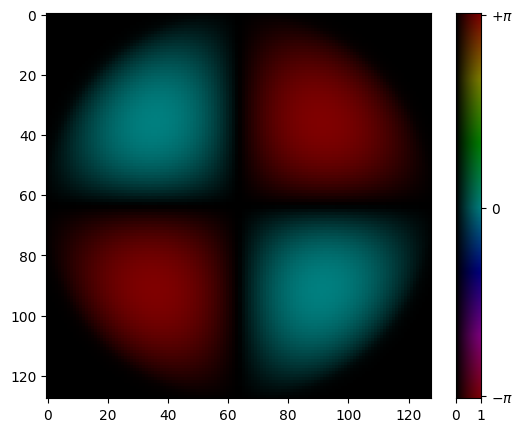

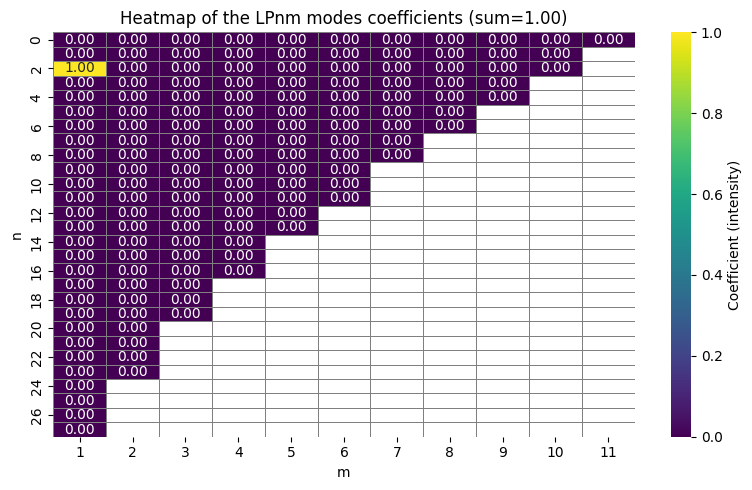

In [61]:
from waveoptics.plots.plots import complex_imshow
from scipy.ndimage import gaussian_filter

propagation_matrix = make_diagonal_mode_coupling_matrix(fiber, fiber_length)
target_field = np.complex64(fiber._modes[:, :, 1, 2])

# target_field = np.zeros_like(target_field)
# target_field[target_field.shape[0] // 2, target_field.shape[1] // 2] = 1
# target_field = gaussian_filter(target_field, sigma=3)


complex_imshow(target_field)

coupled = StepIndexFiberDegenCoupler(target_field, grid, fiber, N_modes=fiber._N_modes_degen)
coupled.show_coefficients(as_heatmap=True)

c:\users\saucourt\coding\mmf_lp_modes\mmfsim\speckle.py:383: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_fmt = pivot.applymap(lambda x: f"{x:.1e}" if pd.notnull(x) else "")


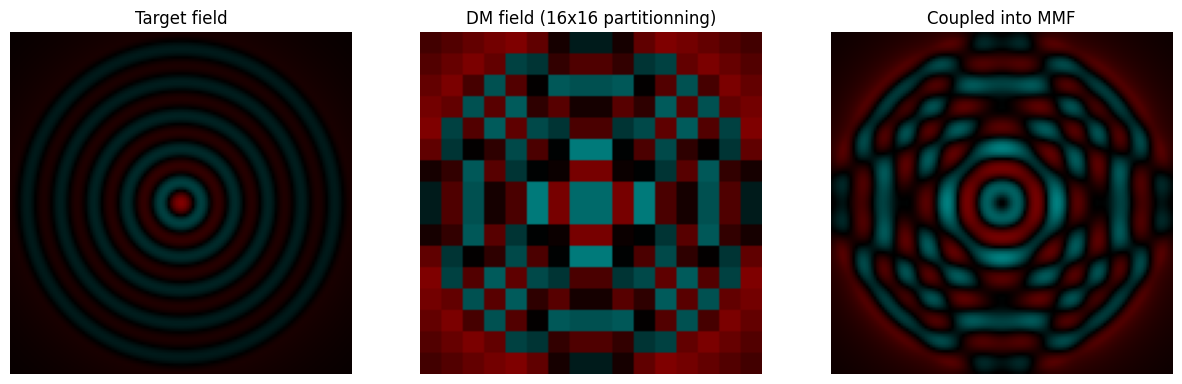

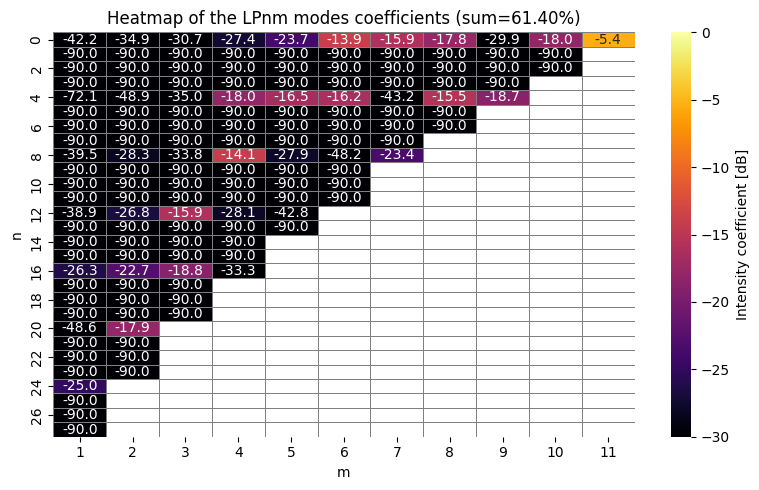

In [98]:
from waveoptics.plots.plots import complex_imshow, complex_to_hsv
from scipy.ndimage import gaussian_filter

mode_number = -1
orientation = 0
dm_n = 16
target_field = np.complex64(fiber._modes[:, :, orientation, mode_number])
new_field = convert_field_to_dm(target_field, n=dm_n)
coupled_in = StepIndexFiberDegenCoupler(new_field, grid, fiber, N_modes=fiber._N_modes_degen)


plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(complex_to_hsv(target_field))
plt.axis('off')
plt.title('Target field')

plt.subplot(1, 3, 2)
plt.imshow(complex_to_hsv(new_field))
plt.axis('off')
plt.title(f'DM field ({dm_n}x{dm_n} partitionning)')

plt.subplot(1, 3, 3)
plt.imshow(complex_to_hsv(coupled_in.field))
plt.title(f'Coupled into MMF')
plt.axis('off')

coupled_in.show_coefficients(as_heatmap=True, log=True)

In [ ]:
es = cma.CMAEvolutionStrategy(
    x0=best_solution,
    sigma0=1/3,
    options={
        'bounds': [-1, 1],
        # 'popsize': 20,
        
    },
)

es.optimize(fitness_func_cplx, iterations=50)
# Get best solution and show it
best_solution = es.result.xbest 
best_value = es.result.fbest
best_eval = es.result.evals_best
fevals = es.result.evaluations

print(f"fevals={fevals}, best_value={best_value}, best_eval={best_eval}")

(9_w,18)-aCMA-ES (mu_w=5.4,w_1=30%) in dimension 128 (seed=112019, Wed Apr 30 12:51:44 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     18 -6.654422501525585e-01 1.0e+00 3.21e-01  3e-01  3e-01 0:03.8
    2     36 -6.637365340289927e-01 1.0e+00 3.12e-01  3e-01  3e-01 0:07.6
    3     54 -6.737137325707252e-01 1.0e+00 3.05e-01  3e-01  3e-01 0:11.4
    4     72 -6.933187470829265e-01 1.0e+00 2.99e-01  3e-01  3e-01 0:15.2
    6    108 -7.331399652817155e-01 1.0e+00 2.87e-01  3e-01  3e-01 0:22.9
    8    144 -7.440812221494220e-01 1.0e+00 2.77e-01  3e-01  3e-01 0:30.6
   10    180 -8.014321422272417e-01 1.0e+00 2.68e-01  3e-01  3e-01 0:38.2
   12    216 -7.712976955640727e-01 1.0e+00 2.62e-01  3e-01  3e-01 0:45.7
   15    270 -7.967239448377406e-01 1.0e+00 2.53e-01  3e-01  3e-01 0:57.0
   18    324 -7.748014261268740e-01 1.0e+00 2.46e-01  2e-01  2e-01 1:08.4
   21    378 -7.926378281090436e-01 1.1e+00 2.38e-01  2e-01  2e-01 1:19.8
   24    432 -8.09551

Pearson intensity: 0.6341742397687296
Quality squared: 0.00510263203861503


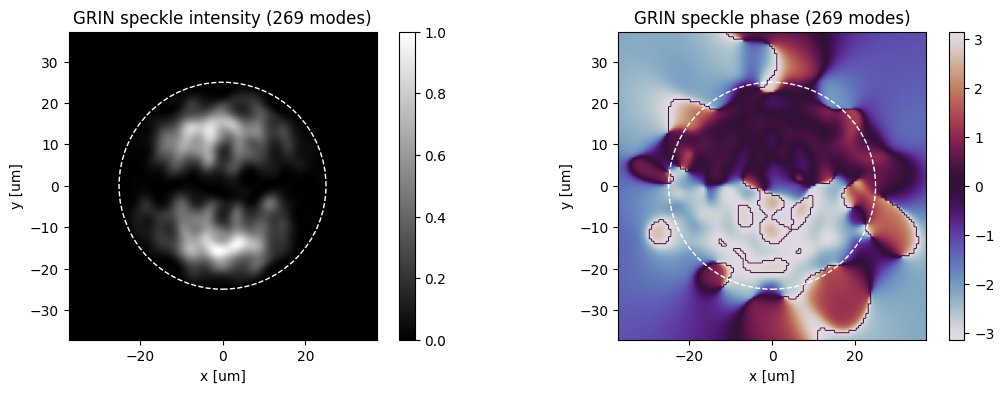

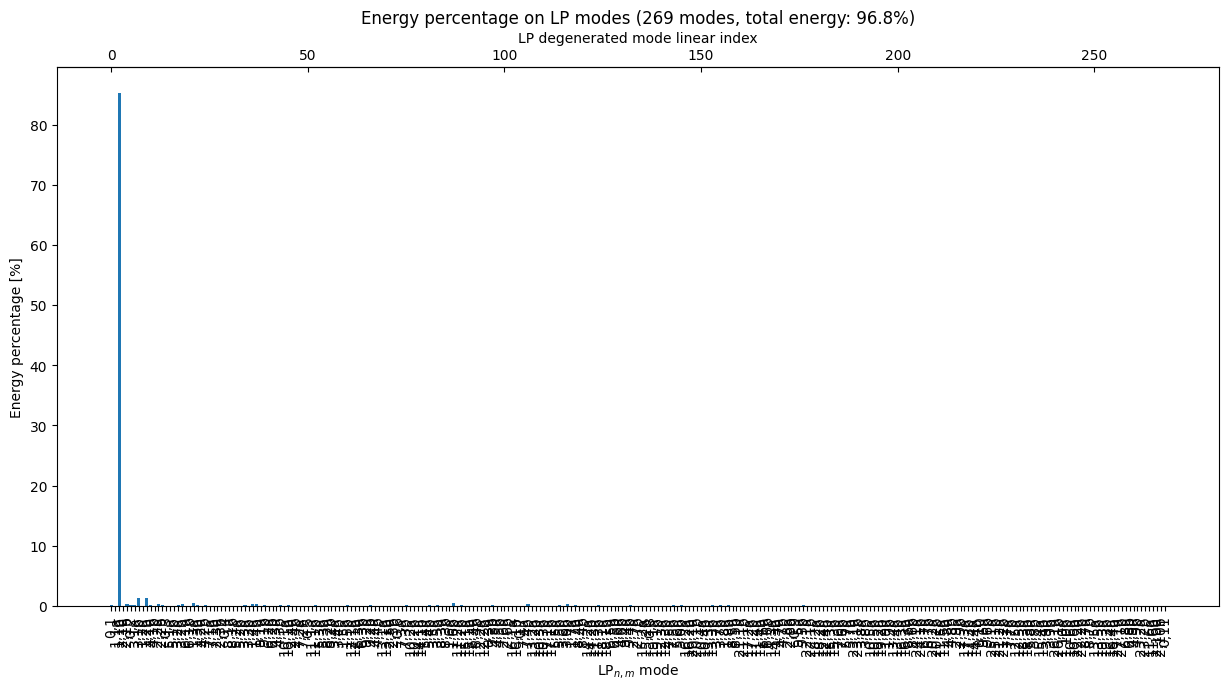

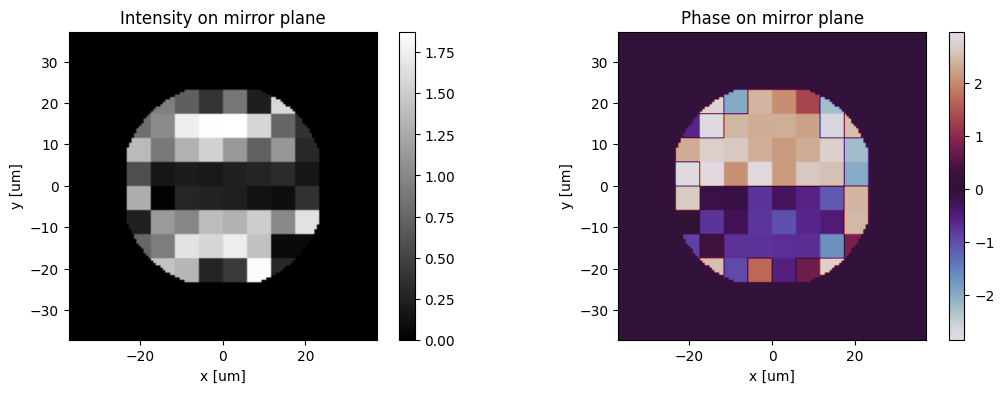

In [32]:
if COMPLEX:
    best_coupled_out = get_output_field_from_reim(best_solution, propagation_matrix)
else:
    best_coupled_out = get_output_field_from_phases(best_solution, propagation_matrix)

pear = pearson(np.square(np.abs(best_coupled_out.field)), np.square(np.abs(target_field)))
qual = quality(best_coupled_out.field, target_field, squared=True)
print(f"Pearson intensity: {pear}")
print(f"Quality squared: {qual}")

# best_coupled_out = get_output_field_from_phases(phi0.flatten(), propagation_matrix)
best_coupled_out.plot(complex=True, complex_hsv=False)
best_coupled_out.plot_coefficients()

plot_dm_from_reim(best_solution)

Now let's create the propagation matrix with no mode energy exchange, this matrix is diagonal.
Then compute the new modes coefficients. Only their phases should have changed.

### Fourier transform the output speckle after padding it

(2048, 2048)
(2048, 2048)


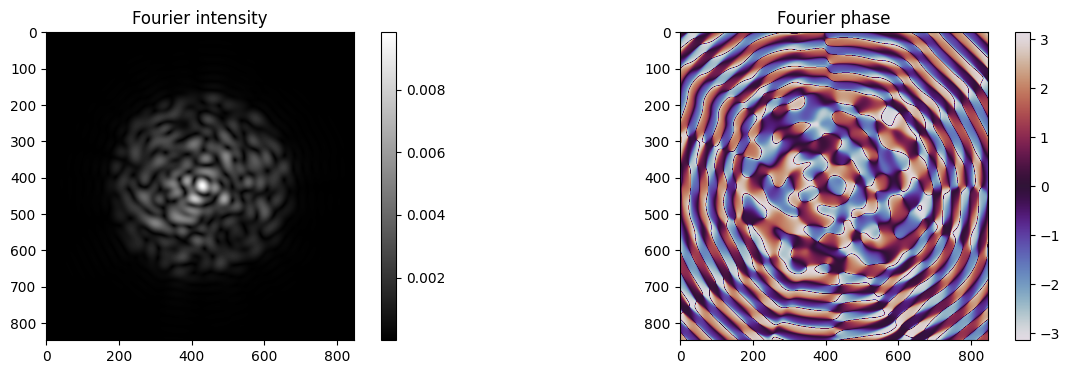

In [506]:
speckle = best_coupled_out.field
pad_amount = (grid_length_fourier - grid_length) // 2
padded_speckle = np.pad(speckle, pad_width=pad_amount)
print(padded_speckle.shape)

speckle_fourier = fourier_transform(padded_speckle)
print(speckle_fourier.shape)

win = slice(600, -600)

fig, axs = plt.subplots(1, 2, figsize=(15,4))
axs[0].set_title('Fourier intensity')
pl0 = axs[0].imshow(np.abs(speckle_fourier[win, win]), cmap='gray')
plt.colorbar(pl0, ax=axs[0])

axs[1].set_title('Fourier phase')
pl1 = axs[1].imshow(np.angle(speckle_fourier[win, win]), cmap='twilight')
plt.colorbar(pl1, ax=axs[1])

### Export for Matlab